<a href="https://colab.research.google.com/github/nidhirajesh006-ui/sentiment-analysis/blob/main/ML_project(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
import os

# --- Download NLTK data (only first time) ---
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# --- Load spaCy English model ---
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading 'en_core_web_sm' model...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# --- Load dataset ---
csv_path = "flipkart_data.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f" File not found: {csv_path}. Please check the file name or path.")

data = pd.read_csv(csv_path)
print("Data loaded successfully!")
print("\n Columns found:", data.columns.tolist())
print("\n Preview of dataset:")
print(data.head())

# --- Choose the text column ---
# Change this if your text column has a different name
text_column = 'description' # Changed from 'review' to 'description'

if text_column not in data.columns:
    raise KeyError(f" Column '{text_column}' not found in the dataset. "
                   f"Please update 'text_column' to match one of: {data.columns.tolist()}")

# --- Preprocessing function ---
def preprocess_texts(texts):
    """
    Clean and lemmatize a list of text strings.
    Combines regex cleaning, stopword removal, and spaCy lemmatization.
    """
    stop_words = set(stopwords.words('english'))
    cleaned_texts = []

    # Use spaCy's efficient pipe for faster processing
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha and token.text.lower() not in stop_words
        ]
        cleaned_texts.append(" ".join(tokens))

    return cleaned_texts

# --- Clean the text ---
print("\n🧹 Preprocessing text, please wait...")
# Added fillna('') to handle potential NaN values in the text column
data['clean_text'] = preprocess_texts(data[text_column].fillna('').astype(str).tolist())

# --- Show results ---
print("\n Sample of cleaned data:")
print(data[[text_column, 'clean_text']].head())

# --- Save cleaned dataset ---
output_path = "flipkart_data_cleaned.csv"
data.to_csv(output_path, index=False)
print(f"\n Preprocessing complete! Cleaned file saved as '{output_path}'.")

FileNotFoundError:  File not found: flipkart_data.csv. Please check the file name or path.

In [ ]:
# Install dependencies if not already installed:
# !pip install scikit-learn gensim transformers torch

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load preprocessed data
data = pd.read_csv("flipkart_data_cleaned.csv")

# Replace with your text column name
text_column = 'clean_text'

# Convert to list
texts = data[text_column].astype(str).tolist()

# ============================================================
# TF-IDF FEATURE EXTRACTION (scikit-learn)
# ============================================================

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # limit to top 5000 features
tfidf_features = tfidf_vectorizer.fit_transform(texts)

print("TF-IDF shape:", tfidf_features.shape)

# ============================================================
#  WORD2VEC FEATURE EXTRACTION (gensim)
# ============================================================

# Tokenize for Word2Vec
tokenized_texts = [text.split() for text in texts]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)

# Create average Word2Vec embeddings for each sentence
def get_avg_word2vec(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)

word2vec_features = np.array([get_avg_word2vec(tokens, w2v_model) for tokens in tokenized_texts])
print("Word2Vec shape:", word2vec_features.shape)

# ============================================================
#  BERT EMBEDDINGS (Hugging Face Transformers)
# ============================================================

# Load pretrained BERT model & tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Take the mean of the last hidden state as the sentence embedding
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply BERT embedding on a small sample (since it's slow)
sample_texts = texts[:200]  # adjust if you want more
bert_embeddings = np.array([get_bert_embedding(t) for t in sample_texts])

print("BERT embeddings shape:", bert_embeddings.shape)

# ============================================================
# SAVE OR USE EMBEDDINGS
# ============================================================

# Example: convert TF-IDF to DataFrame and save
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.to_csv("flipkart_tfidf_features.csv", index=False)

# Example: save Word2Vec embeddings
pd.DataFrame(word2vec_features).to_csv("flipkart_word2vec_features.csv", index=False)

# Example: save BERT embeddings
pd.DataFrame(bert_embeddings).to_csv("flipkart_bert_embeddings.csv", index=False)

print("Feature extraction complete! Files saved:")
print("   • flipkart_tfidf_features.csv")
print("   • flipkart_word2vec_features.csv")
print("   • flipkart_bert_embeddings.csv")

TF-IDF shape: (12041, 5000)
Word2Vec shape: (12041, 100)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BERT embeddings shape: (200, 768)
Feature extraction complete! Files saved:
   • flipkart_tfidf_features.csv
   • flipkart_word2vec_features.csv
   • flipkart_bert_embeddings.csv


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfre

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress the UndefinedMetricWarning that can occur when a class is missing in the test set
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# For SVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# For LSTM
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For BERT
# from transformers import BertTokenizer, TFBertForSequenceClassification
# import tensorflow as tf

# ============================================
# Load Dataset
# ============================================
data = pd.read_csv("flipkart_data_cleaned.csv")

# Change column names as per your dataset
text_column = "clean_text"
label_column = "product_rating"

# Check if text column exists
if text_column not in data.columns:
    raise KeyError(f" Text column '{text_column}' not found in the dataset.")

# Check if label column exists
if label_column not in data.columns:
    raise KeyError(f" Label column '{label_column}' not found in the dataset.")

# Check if product_rating is in expected range and remove rows with invalid ratings
valid_ratings = data[label_column].isin([1, 2, 3, 4, 5])
if not valid_ratings.all():
    print(f" Warning: Removing {len (data) - valid_ratings.sum()} rows with invalid product ratings.")
    data = data[valid_ratings].copy()

# Ensure the text column is string type and handle potential NaNs before splitting
data[text_column] = data[text_column].astype(str).fillna('')


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data[text_column], data[label_column], test_size=0.2, random_state=42
)

# Since product_rating is 1-5, adjust target labels to be 0-4 for 0-indexed classification
y_train = y_train - 1
y_test = y_test - 1


# ==========================================================
# 1️ SVM MODEL (with TF-IDF)
# ==========================================================
print("🧩 Training SVM Model...")

tfidf = TfidfVectorizer(max_features=5000)
# Explicitly handle potential NaNs in train/test sets before vectorizing
X_train_tfidf = tfidf.fit_transform(X_train.fillna(''))
X_test_tfidf = tfidf.transform(X_test.fillna(''))


# LinearSVC works with multi-class out of the box
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)

# Adjust target names for classification report (ratings 1-5)
target_names_svm = [str(rating) for rating in range(1, 6)]
# Pass the unique labels from y_test to classification_report
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds, labels=np.unique(y_test), target_names=target_names_svm))


# ==========================================================
# 2️LSTM MODEL (with Word2Vec embeddings)
# ==========================================================
print("\n Training LSTM Model...")

# Tokenize text
tokenizer = Tokenizer()
# Ensure texts are strings and handle potential NaNs before fitting tokenizer
tokenizer.fit_on_texts(X_train.fillna('').tolist())
vocab_size = len(tokenizer.word_index) + 1

# Ensure texts are strings and handle potential NaNs before sequencing
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train.fillna('').tolist()), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test.fillna('').tolist()), maxlen=100)

# Train Word2Vec
# Ensure sentences are not empty lists after handling NaNs
sentences = [text.split() for text in X_train.fillna('').tolist() if isinstance(text, str) and text.strip()]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Create Embedding Matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Build LSTM Model
# Number of classes is now 5 (for ratings 1-5)
model_lstm = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(5, activation='softmax') # Output layer for 5 classes
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

lstm_preds = np.argmax(model_lstm.predict(X_test_seq), axis=1)
print("✅ LSTM Accuracy:", accuracy_score(y_test, lstm_preds))
# Adjust target names for classification report (ratings 1-5)
target_names_lstm = [str(rating) for rating in range(1, 6)]
# Pass the unique labels from y_test to classification_report
print(classification_report(y_test, lstm_preds, labels=np.unique(y_test), target_names=target_names_lstm))


# ==========================================================
# 3️ BERT MODEL (Fine-tuning for Sentiment Classification)
# ==========================================================
# print("\n Training BERT Model... (this will take longer)")

# tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

# def encode_texts(texts, tokenizer, max_len=128):
#     # Ensure texts are strings and handle potential NaN values before encoding
#     texts = [str(text) if pd.notna(text) else '' for text in texts.fillna('').tolist()]
#     return tokenizer(
#         list(texts), padding=True, truncation=True, return_tensors='tf', max_length=max_len
#     )

# train_encodings = encode_texts(X_train, tokenizer_bert)
# test_encodings = encode_texts(X_test, tokenizer_bert)

# # Number of labels is now 5 (for ratings 1-5)
# model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# model_bert.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
#     # Use SparseCategoricalCrossentropy for integer labels
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

# history = model_bert.fit(
#     dict(train_encodings),
#     y_train,
#     validation_split=0.1,
#     epochs=2,
#     batch_size=8
# )

# bert_preds = np.argmax(model_bert.predict(dict(test_encodings)).logits, axis=1)
# print(" BERT Accuracy:", accuracy_score(y_test, bert_preds))
# # Adjust target names for classification report (ratings 1-5)
# target_names_bert = [str(rating) for rating in range(1, 6)]
# # Pass the unique labels from y_test to classification_report
# print(classification_report(y_test, bert_preds, labels=np.unique(y_test), target_names=target_names_bert))

🧩 Training SVM Model...
SVM Accuracy: 0.9424657534246575
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      0.14      0.22         7
           3       0.95      0.99      0.97       343
           4       0.67      0.14      0.24        14

    accuracy                           0.94       365
   macro avg       0.53      0.32      0.36       365
weighted avg       0.93      0.94      0.92       365


 Training LSTM Model...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 4, does not match size of target_names, 5
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.8230 - loss: 1.1453 - val_accuracy: 0.9589 - val_loss: 0.2087
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.9337 - loss: 0.3012 - val_accuracy: 0.9589 - val_loss: 0.2161
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.9237 - loss: 0.3314 - val_accuracy: 0.9589 - val_loss: 0.2139
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.9347 - loss: 0.2915 - val_accuracy: 0.9589 - val_loss: 0.2222
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step - accuracy: 0.9221 - loss: 0.3377 - val_accuracy: 0.9589 - val_loss: 0.2093
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
✅ LSTM Accuracy: 0.9397260273972603
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         7
           3       0.94      1.00      0.97       343
           4       0.00      0.00      0.00        14

    accuracy            

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 4, does not match size of target_names, 5
  warnings.warn(


🧩 Training SVM Model...
 SVM Accuracy: 0.9835616438356164
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
     Neutral       1.00      0.25      0.40         8
    Positive       0.98      1.00      0.99       356

    accuracy                           0.98       365
   macro avg       0.99      0.75      0.80       365
weighted avg       0.98      0.98      0.98       365


 SVM Model Evaluation Metrics
-----------------------------
Accuracy  : 0.9836
Precision : 0.9945
Recall    : 0.7500
F1 Score  : 0.7972


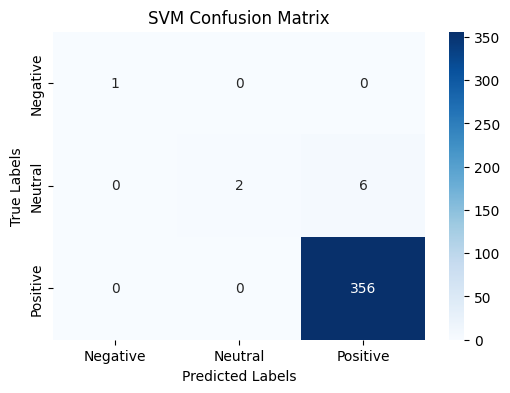


Training LSTM Model...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - accuracy: 0.9807 - loss: 0.6499 - val_accuracy: 0.9589 - val_loss: 0.2241
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.9714 - loss: 0.1493 - val_accuracy: 0.9589 - val_loss: 0.2110
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.9763 - loss: 0.1213 - val_accuracy: 0.9589 - val_loss: 0.1978
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 517ms/step - accuracy: 0.9787 - loss: 0.1148 - val_accuracy: 0.9589 - val_loss: 0.1955
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.9724 - loss: 0.1366 - val_accuracy: 0.9589 - val_loss: 0.1995
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
 LSTM Accuracy: 0.9753424657534246
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
     Neutral       0.00      0.00      0.00         8
    Positive       0.98      1.00      0.99       356

    accuracy                           0.98       365
   macro avg       0.33 

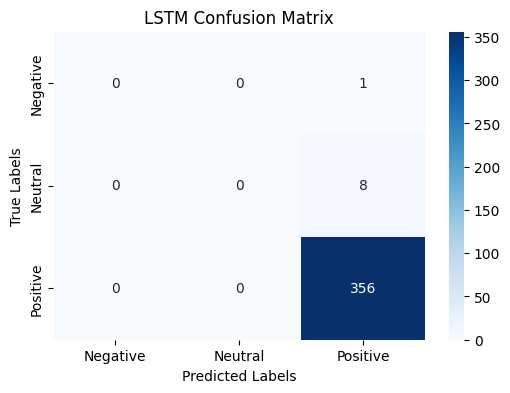

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the UndefinedMetricWarning that can occur when a class is missing in the test set
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# For SVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# For LSTM
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For BERT
# from transformers import BertTokenizer, TFBertForSequenceClassification
# import tensorflow as tf

# ============================================
# Load Dataset
# ============================================
data = pd.read_csv("flipkart_data_cleaned.csv")

# Change column names as per your dataset
text_column = "clean_text"
# label_column = "product_rating" # Original 5-class rating

# Check if text column exists
if text_column not in data.columns:
    raise KeyError(f" Text column '{text_column}' not found in the dataset.")

# Check if product_rating exists before mapping
if "product_rating" not in data.columns:
     raise KeyError(f" Column 'product_rating' not found in the dataset. Cannot create 3 classes.")

# --- Map 5 ratings to 3 classes ---
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0 # Negative
    elif rating == 3:
        return 1 # Neutral
    elif rating in [4, 5]:
        return 2 # Positive
    else:
        return -1 # Invalid rating

data['sentiment_class'] = data['product_rating'].apply(map_rating_to_sentiment)

# Remove rows with invalid mapped ratings (-1)
valid_sentiment = data['sentiment_class'] != -1
if not valid_sentiment.all():
    print(f" Warning: Removing {len(data) - valid_sentiment.sum()} rows with invalid sentiment mappings.")
    data = data[valid_sentiment].copy()

# Set the new label column
label_column = 'sentiment_class'

# Ensure the text column is string type and handle potential NaNs before splitting
data[text_column] = data[text_column].astype(str).fillna('')


# Split data
# Use the new sentiment_class column as the label
X_train, X_test, y_train, y_test = train_test_split(
    data[text_column], data[label_column], test_size=0.2, random_state=42, stratify=data[label_column] # Added stratify
)

# y_train and y_test are already 0, 1, or 2, so no need to adjust for 0-indexing


# ==========================================================
# 1️ SVM MODEL (with TF-IDF)
# ==========================================================
print("🧩 Training SVM Model...")

tfidf = TfidfVectorizer(max_features=5000)
# Explicitly handle potential NaNs in train/test sets before vectorizing
X_train_tfidf = tfidf.fit_transform(X_train.fillna(''))
X_test_tfidf = tfidf.transform(X_test.fillna(''))


# LinearSVC works with multi-class out of the box
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)

# Adjust target names for classification report (3 classes)
target_names_svm = ["Negative", "Neutral", "Positive"]
# Pass the unique labels from y_test to classification_report
print(" SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds, labels=np.unique(y_test), target_names=target_names_svm))

# SVM Model Evaluation
print("\n SVM Model Evaluation Metrics")
print("-----------------------------")
print(f"Accuracy  : {accuracy_score(y_test, svm_preds):.4f}")
print(f"Precision : {precision_score(y_test, svm_preds, average='macro', zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, svm_preds, average='macro', zero_division=0):.4f}")
print(f"F1 Score  : {f1_score(y_test, svm_preds, average='macro', zero_division=0):.4f}")

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, svm_preds, labels=np.unique(y_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_svm, yticklabels=target_names_svm)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM Confusion Matrix')
plt.show()


# ==========================================================
# 2️ LSTM MODEL (with Word2Vec embeddings)
# ==========================================================
print("\nTraining LSTM Model...")

# Tokenize text
tokenizer = Tokenizer()
# Ensure texts are strings and handle potential NaNs before fitting tokenizer
tokenizer.fit_on_texts(X_train.fillna('').tolist())
vocab_size = len(tokenizer.word_index) + 1

# Ensure texts are strings and handle potential NaNs before sequencing
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train.fillna('').tolist()), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test.fillna('').tolist()), maxlen=100)

# Train Word2Vec
# Ensure sentences are not empty lists after handling NaNs
sentences = [text.split() for text in X_train.fillna('').tolist() if isinstance(text, str) and text.strip()]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Create Embedding Matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Build LSTM Model
# Number of classes is now 3
model_lstm = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax') # Output layer for 3 classes
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

lstm_preds = np.argmax(model_lstm.predict(X_test_seq), axis=1)
print(" LSTM Accuracy:", accuracy_score(y_test, lstm_preds))
# Adjust target names for classification report (3 classes)
target_names_lstm = ["Negative", "Neutral", "Positive"]
# Pass the unique labels from y_test to classification_report
print(classification_report(y_test, lstm_preds, labels=np.unique(y_test), target_names=target_names_lstm))

# LSTM Model Evaluation
print("\n LSTM Model Evaluation Metrics")
print("-----------------------------")
print(f"Accuracy  : {accuracy_score(y_test, lstm_preds):.4f}")
print(f"Precision : {precision_score(y_test, lstm_preds, average='macro', zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, lstm_preds, average='macro', zero_division=0):.4f}")
print(f"F1 Score  : {f1_score(y_test, lstm_preds, average='macro', zero_division=0):.4f}")

# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test, lstm_preds, labels=np.unique(y_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_lstm, yticklabels=target_names_lstm)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('LSTM Confusion Matrix')
plt.show()

 Data loaded successfully!

 Columns found: ['category_1', 'category_2', 'category_3', 'title', 'product_rating', 'selling_price', 'mrp', 'seller_name', 'seller_rating', 'description', 'highlights', 'image_links']

 Preview:
               category_1 category_2 category_3  \
0  Sports, Books and More     Sports   Cricket    
1  Sports, Books and More     Sports   Cricket    
2  Sports, Books and More     Sports   Cricket    
3  Sports, Books and More     Sports   Cricket    
4  Sports, Books and More     Sports   Cricket    

                                               title  product_rating  \
0  ITWOSERVICES CRICKET NET 100X10 CRICKET NET NY...             4.4   
1  ITWOSERVICES CRICKET NET GROUND BOUNDARY NET 1...             4.4   
2  VICTORY Medium Weight ( Pack of 1 ) Rubber Cri...             3.7   
3  VICTORY Cricket Wind Ball (Pack of 1) - Made i...             3.8   
4  CEAT Hitman Full Size Double Blade Poplar Cric...             3.4   

  selling_price     mrp     seller_

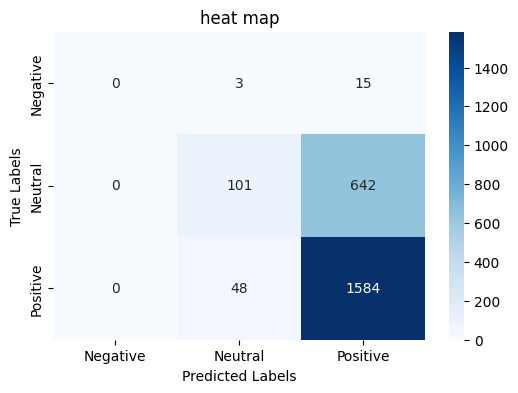


Saved file: 'flipkart_data_with_predictions.csv'
 All steps complete!


In [ ]:
import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np # Import numpy for unique labels

# ============================================
# 2️ Download Required Data
# ============================================
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Load spaCy English model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading 'en_core_web_sm' model...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# ============================================
# 3️ Load Dataset
# ============================================
csv_path = "flipkart data.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f" File not found: {csv_path}")

data = pd.read_csv(csv_path)
print(" Data loaded successfully!")
print("\n Columns found:", data.columns.tolist())
print("\n Preview:")
print(data.head())

# ============================================
# 4️ Choose Text and Target Columns
# ============================================
# Update column names as per your CSV file
text_column = 'description'      # column containing text
# target_column = 'sentiment' # column containing sentiment labels (Positive, Negative, Neutral)

if text_column not in data.columns:
    raise KeyError(f" Ensure your dataset has '{text_column}' column.")

# Check if product_rating exists before mapping
if "product_rating" not in data.columns:
     raise KeyError(f" Column 'product_rating' not found in the dataset. Cannot create sentiment classes.")

# --- Map 5 ratings to 3 classes ---
def map_rating_to_sentiment(rating):
    # Handle non-numeric ratings before mapping
    if pd.isna(rating):
        return -1 # Indicate invalid/missing rating
    try:
        rating = int(rating)
    except (ValueError, TypeError):
        return -1 # Indicate invalid/non-integer rating

    if rating in [1, 2]:
        return 0 # Negative
    elif rating == 3:
        return 1 # Neutral
    elif rating in [4, 5]:
        return 2 # Positive
    else:
        return -1 # Indicate invalid rating outside 1-5 range

data['sentiment_class'] = data['product_rating'].apply(map_rating_to_sentiment)

# Remove rows with invalid mapped ratings (-1)
valid_sentiment = data['sentiment_class'] != -1
if not valid_sentiment.all():
    print(f" Warning: Removing {len(data) - valid_sentiment.sum()} rows with invalid sentiment mappings.")
    data = data[valid_sentiment].copy()

# Set the new label column
target_column = 'sentiment_class'


# ============================================
# 5️ Text Preprocessing Function
# ============================================
def preprocess_texts(texts):
    stop_words = set(stopwords.words('english'))
    cleaned_texts = []

    # Ensure texts are strings before processing
    texts = [str(text) if pd.notna(text) else '' for text in texts]

    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha and token.text.lower() not in stop_words
        ]
        cleaned_texts.append(" ".join(tokens))

    return cleaned_texts

print("\n Cleaning text data, please wait...")
data['clean_text'] = preprocess_texts(data[text_column].astype(str).tolist())

# ============================================
# 6️Split Data into Train/Test
# ============================================
X = data['clean_text']
y = data[target_column]

# Ensure stratify works by handling potential missing classes in small splits (though less likely with sentiment mapping)
# and handling potential NaNs in X (already done by preprocess_texts)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) > 1 else None) # Added stratify condition
print(" Data split into train and test sets.")

# ============================================
# 7️Text Vectorization (TF-IDF)
# ============================================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
# Explicitly handle potential NaNs in X_train and X_test before vectorizing
X_train_tfidf = vectorizer.fit_transform(X_train.fillna(''))
X_test_tfidf = vectorizer.transform(X_test.fillna(''))


# ============================================
# 8️ Model Training
# ============================================
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
print("Model training complete!")

# ============================================
# 9️ Model Prediction
# ============================================
y_pred = model.predict(X_test_tfidf)

# ============================================
# Model Evaluation
# ============================================
# Adjust target names for classification report (3 classes)
target_names = ["Negative", "Neutral", "Positive"]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0) # Added zero_division
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)   # Added zero_division
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)       # Added zero_division


print("\n Model Evaluation Metrics")
print("-----------------------------")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Classification Report
print("\nDetailed Classification Report:")
# Pass the unique labels from y_test to classification_report
print(classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=target_names, zero_division=0)) # Added zero_division

# Confusion Matrix
# Pass the unique labels from y_test to confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('heat map')
plt.show()

# ============================================
# 1 Save Cleaned + Predicted Data (optional)
# ============================================
# Ensure 'clean_text' is in a format vectorizer can handle for the whole dataset prediction
data['predicted_sentiment'] = model.predict(vectorizer.transform(data['clean_text'].fillna('')))
data.to_csv("flipkart_data_with_predictions.csv", index=False)
print("\nSaved file: 'flipkart_data_with_predictions.csv'")
print(" All steps complete!")

# ============================================
#  Sentiment Visualization Dashboard
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import pandas as pd

# --- Ensure predictions exist and data is loaded ---
# Assuming data is already loaded in a previous cell (e.g., 8GgrVy9s9lSl or 44261a46)
# If not, uncomment the following lines to load the data:
# try:
#     data = pd.read_csv("flipkart_data_with_predictions.csv")
# except FileNotFoundError:
#     print(" 'flipkart_data_with_predictions.csv' not found. Please run the model training cell first.")
#     # You might want to exit or handle this case differently

# Check if the necessary columns exist
if 'sentiment_class' not in data.columns:
     raise KeyError(" 'sentiment_class' column not found. Please run the data mapping code first.")
if 'predicted_sentiment' not in data.columns:
    print(" 'predicted_sentiment' not found. Generating predictions for the whole dataset...")
    # Assuming 'model' and 'vectorizer' are available from a previous cell (e.g., 8GgrVy9s9lSl)
    # If not, you would need to reload/re-train the model and vectorizer here.
    try:
        # Assuming vectorizer and model objects are available globally or passed
        # If not, load/recreate them based on your trained model (e.g., Logistic Regression from 8GgrVy9s9lSl)
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.linear_model import LogisticRegression
        # Example (you might need to load these from saved files if not in global scope):
        # vectorizer = ...
        # model = ...
        if 'vectorizer' in globals() and 'model' in globals():
             data['predicted_sentiment'] = model.predict(vectorizer.transform(data['clean_text'].fillna('')))
             print(" Predictions generated.")
        else:
            raise NameError(" 'vectorizer' or 'model' not found. Cannot generate predictions.")

    except NameError as e:
        print(f" Could not generate predictions: {e}. Please ensure the model training cell has been run and the objects are available.")
        # You might want to exit or handle this case differently
    except Exception as e:
        print(f" An error occurred during prediction: {e}")
        # Handle other potential errors during prediction


# --- Define unique sentiment labels ---
# Use the unique values from the true sentiment column for consistent labels
labels = sorted(data['sentiment_class'].unique())

# Define target names corresponding to the numerical labels (0, 1, 2)
target_names = ["Negative", "Neutral", "Positive"]
# Ensure target_names align with labels if some classes are missing
mapped_target_names = [name for i, name in enumerate(target_names) if i in labels]


# ============================================
# 1️Sentiment Distribution (True)
# ============================================
plt.figure(figsize=(6,4))
# Use 'sentiment_class' for true sentiment
sns.countplot(x='sentiment_class', data=data, palette='Set2')
plt.title('Distribution of True Sentiments')
plt.xlabel('Sentiment Class (0:Negative, 1:Neutral, 2:Positive)')
plt.ylabel('Count')
plt.xticks(ticks=labels, labels=mapped_target_names) # Set tick labels
plt.show()

# ============================================
# 2️Sentiment Distribution (Predicted)
# ============================================
plt.figure(figsize=(6,4))
# Use 'predicted_sentiment' for predicted sentiment
sns.countplot(x='predicted_sentiment', data=data, palette='Set1')
plt.title('Distribution of Predicted Sentiments')
plt.xlabel('Predicted Sentiment Class (0:Negative, 1:Neutral, 2:Positive)')
plt.ylabel('Count')
plt.xticks(ticks=labels, labels=mapped_target_names) # Set tick labels
plt.show()

# ============================================
# 3️True vs Predicted Comparison
# ============================================
plt.figure(figsize=(6,4))
# Use 'sentiment_class' and 'predicted_sentiment'
sns.histplot(data=data, x='sentiment_class', hue='predicted_sentiment', multiple='dodge', shrink=0.8, palette='coolwarm', discrete=True)
plt.title('Comparison: True vs Predicted Sentiments')
plt.xlabel('True Sentiment Class (0:Negative, 1:Neutral, 2:Positive)')
plt.ylabel('Count')
plt.xticks(ticks=labels, labels=mapped_target_names) # Set tick labels for x-axis
# Optional: Set tick labels for hue legend if needed, depends on seaborn version
# plt.legend(title='Predicted', labels=mapped_target_names) # Example for manual legend if needed
plt.show()


# ============================================
# 4️Confusion Matrix
# ============================================
# Use 'sentiment_class' and 'predicted_sentiment'
cm = confusion_matrix(data['sentiment_class'], data['predicted_sentiment'], labels=labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=mapped_target_names, yticklabels=mapped_target_names)
plt.title('Confusion Matrix (True vs Predicted)')
plt.xlabel('Predicted Sentiment Class')
plt.ylabel('True Sentiment Class')
plt.show()

# ============================================
# 5️ Word Clouds for Each Predicted Sentiment
# ============================================
from wordcloud import STOPWORDS

print("\n Generating Word Clouds for each Predicted Sentiment...")
# Use 'predicted_sentiment' for grouping
for sentiment_value in sorted(data['predicted_sentiment'].unique()):
    # Map numerical value back to target name for title
    sentiment_name = target_names[sentiment_value] if sentiment_value in range(len(target_names)) else f"Class {sentiment_value}"
    text = " ".join(data.loc[data['predicted_sentiment'] == sentiment_value, 'clean_text'].fillna('')) # Handle NaNs in clean_text
    if len(text.strip()) == 0:
        continue  # skip empty classes
    wc = WordCloud(width=800, height=400, background_color='white',
                   stopwords=STOPWORDS, colormap='viridis').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Predicted {sentiment_name} Reviews')
    plt.show()

print("\nVisualization Dashboard Complete!")

/tmp/ipython-input-1801568123.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_class', data=data, palette='Set2')


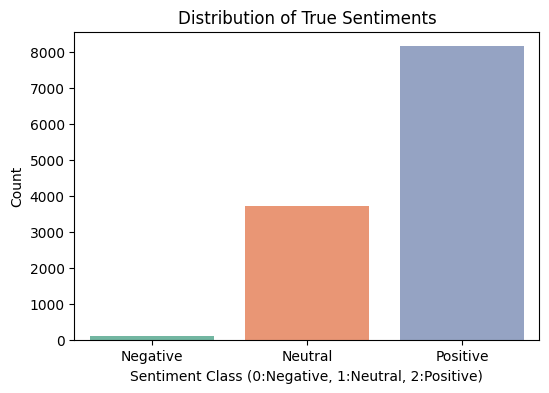

/tmp/ipython-input-1801568123.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_sentiment', data=data, palette='Set1')


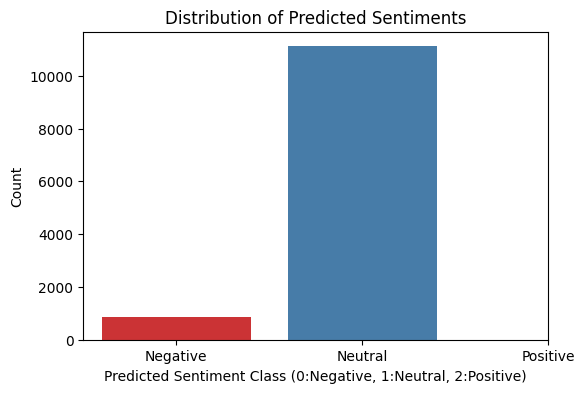

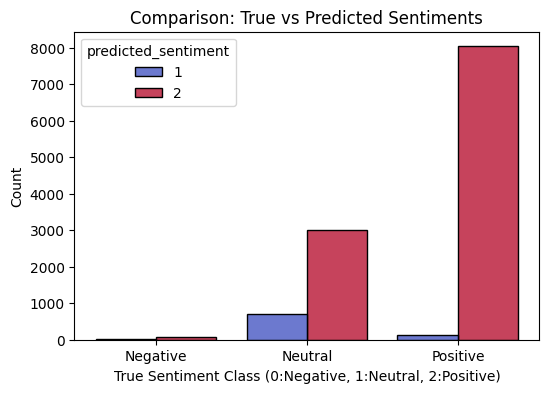

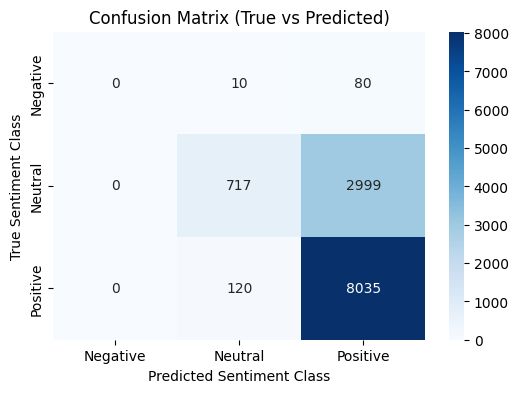


 Generating Word Clouds for each Predicted Sentiment...


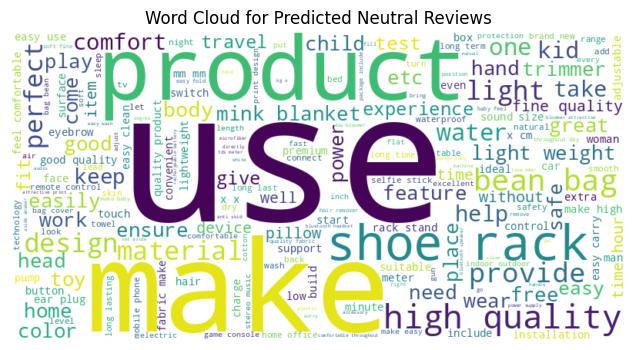

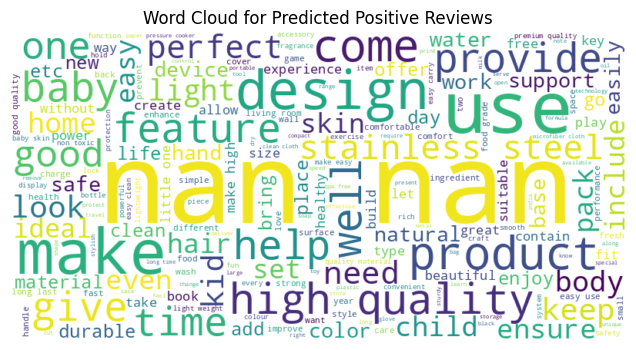


Visualization Dashboard Complete!


In [ ]:
# ============================================
#  Sentiment Visualization Dashboard
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import pandas as pd

# --- Ensure predictions exist and data is loaded ---
# Assuming data is already loaded in a previous cell (e.g., 8GgrVy9s9lSl or 44261a46)
# If not, uncomment the following lines to load the data:
# try:
#     data = pd.read_csv("flipkart_data_with_predictions.csv")
# except FileNotFoundError:
#     print(" 'flipkart_data_with_predictions.csv' not found. Please run the model training cell first.")
#     # You might want to exit or handle this case differently

# Check if the necessary columns exist
if 'sentiment_class' not in data.columns:
     raise KeyError(" 'sentiment_class' column not found. Please run the data mapping code first.")
if 'predicted_sentiment' not in data.columns:
    print(" 'predicted_sentiment' not found. Generating predictions for the whole dataset...")
    # Assuming 'model' and 'vectorizer' are available from a previous cell (e.g., 8GgrVy9s9lSl)
    # If not, you would need to reload/re-train the model and vectorizer here.
    try:
        # Assuming vectorizer and model objects are available globally or passed
        # If not, load/recreate them based on your trained model (e.g., Logistic Regression from 8GgrVy9s9lSl)
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.linear_model import LogisticRegression
        # Example (you might need to load these from saved files if not in global scope):
        # vectorizer = ...
        # model = ...
        if 'vectorizer' in globals() and 'model' in globals():
             data['predicted_sentiment'] = model.predict(vectorizer.transform(data['clean_text'].fillna('')))
             print(" Predictions generated.")
        else:
            raise NameError(" 'vectorizer' or 'model' not found. Cannot generate predictions.")

    except NameError as e:
        print(f" Could not generate predictions: {e}. Please ensure the model training cell has been run and the objects are available.")
        # You might want to exit or handle this case differently
    except Exception as e:
        print(f" An error occurred during prediction: {e}")
        # Handle other potential errors during prediction


# --- Define unique sentiment labels ---
# Use the unique values from the true sentiment column for consistent labels
labels = sorted(data['sentiment_class'].unique())

# Define target names corresponding to the numerical labels (0, 1, 2)
target_names = ["Negative", "Neutral", "Positive"]
# Ensure target_names align with labels if some classes are missing
mapped_target_names = [name for i, name in enumerate(target_names) if i in labels]


# ============================================
# 1️Sentiment Distribution (True)
# ============================================
plt.figure(figsize=(6,4))
# Use 'sentiment_class' for true sentiment
sns.countplot(x='sentiment_class', data=data, palette='Set2')
plt.title('Distribution of True Sentiments')
plt.xlabel('Sentiment Class (0:Negative, 1:Neutral, 2:Positive)')
plt.ylabel('Count')
plt.xticks(ticks=labels, labels=mapped_target_names) # Set tick labels
plt.show()

# ============================================
# 2️Sentiment Distribution (Predicted)
# ============================================
plt.figure(figsize=(6,4))
# Use 'predicted_sentiment' for predicted sentiment
sns.countplot(x='predicted_sentiment', data=data, palette='Set1')
plt.title('Distribution of Predicted Sentiments')
plt.xlabel('Predicted Sentiment Class (0:Negative, 1:Neutral, 2:Positive)')
plt.ylabel('Count')
plt.xticks(ticks=labels, labels=mapped_target_names) # Set tick labels
plt.show()

# ============================================
# 3️True vs Predicted Comparison
# ============================================
plt.figure(figsize=(6,4))
# Use 'sentiment_class' and 'predicted_sentiment'
sns.histplot(data=data, x='sentiment_class', hue='predicted_sentiment', multiple='dodge', shrink=0.8, palette='coolwarm', discrete=True)
plt.title('Comparison: True vs Predicted Sentiments')
plt.xlabel('True Sentiment Class (0:Negative, 1:Neutral, 2:Positive)')
plt.ylabel('Count')
plt.xticks(ticks=labels, labels=mapped_target_names) # Set tick labels for x-axis
# Optional: Set tick labels for hue legend if needed, depends on seaborn version
# plt.legend(title='Predicted', labels=mapped_target_names) # Example for manual legend if needed
plt.show()


# ============================================
# 4️Confusion Matrix
# ============================================
# Use 'sentiment_class' and 'predicted_sentiment'
cm = confusion_matrix(data['sentiment_class'], data['predicted_sentiment'], labels=labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=mapped_target_names, yticklabels=mapped_target_names)
plt.title('Confusion Matrix (True vs Predicted)')
plt.xlabel('Predicted Sentiment Class')
plt.ylabel('True Sentiment Class')
plt.show()

# ============================================
# 5️ Word Clouds for Each Predicted Sentiment
# ============================================
from wordcloud import STOPWORDS

print("\n Generating Word Clouds for each Predicted Sentiment...")
# Use 'predicted_sentiment' for grouping
for sentiment_value in sorted(data['predicted_sentiment'].unique()):
    # Map numerical value back to target name for title
    sentiment_name = target_names[sentiment_value] if sentiment_value in range(len(target_names)) else f"Class {sentiment_value}"
    text = " ".join(data.loc[data['predicted_sentiment'] == sentiment_value, 'clean_text'].fillna('')) # Handle NaNs in clean_text
    if len(text.strip()) == 0:
        continue  # skip empty classes
    wc = WordCloud(width=800, height=400, background_color='white',
                   stopwords=STOPWORDS, colormap='viridis').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Predicted {sentiment_name} Reviews')
    plt.show()

print("\nVisualization Dashboard Complete!")